In [1]:
from sklearn.datasets import load_iris
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from quask.core import Ansatz, Kernel, KernelFactory, KernelType
from quask.core_implementation import QiskitKernel

In [3]:

N_ELEMENTS_PER_CLASS = 10
iris = load_iris()
X = np.row_stack([iris.data[0:N_ELEMENTS_PER_CLASS], iris.data[50:50+N_ELEMENTS_PER_CLASS]])
y = np.array([0] * N_ELEMENTS_PER_CLASS + [1] * N_ELEMENTS_PER_CLASS)

In [4]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5454)

LOAD NETWORK DATASET

In [ ]:
qX1 = np.load('Anomaly_Detection_Protons/background_subsampled.npy')
qX2 = np.load('Anomaly_Detection_Protons/signal_AtoH_to_ZZZ_subsampled.npy')

In [ ]:
qX1 = qX1[:10,:]
qX2 = qX2[:10,:]

In [ ]:
qX = np.row_stack([qX1, qX2])
qy = np.array([-1] * len(qX1) + [1] * len(qX2))

print(f"{qX.shape=}")
print(f"{qy.shape=}")

In [ ]:
qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

print("Shape training set:", qX_train.shape, qy_train.shape)
print("Shape testing set:", qX_test.shape, qy_test.shape)
print("Example of feature:", qX_train[0])
print("Example of label:", qy_train[0])

In [5]:
# Instantiate a machine learning model
model = SVC(kernel='precomputed')

In [34]:
# Create a quantum kernel
ansatz = Ansatz(n_features=4, n_qubits=4, n_operations=4)
ansatz.initialize_to_identity()
# create a circular entanglement circuit
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.9)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XX", new_bandwidth=0.9)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XX", new_bandwidth=0.9)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="XX", new_bandwidth=0.9)

from quask.core_implementation import QiskitKernel
kernel = QiskitKernel(ansatz, "Z" * 4, KernelType.FIDELITY, platform="infty_shots")


def create_qiskit_noiseless(ansatz: Ansatz, measurement: str, type: KernelType):
    return QiskitKernel(ansatz, measurement, type, n_shots=None)

# if you have already added the implementation comment the line below and set the current implementation
# KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
KernelFactory.set_current_implementation('qiskit_noiseless')

# remember we set the kernel with the 'qiskit_noiseless' implementation
kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

# Fit the model to the training data
K_train = kernel.build_kernel(X_train, X_train)
model.fit(K_train, y_train)

ValueError: Expected 2D array, got scalar array instead:
array=nan.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
print(

None


In [27]:
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService

# service = QiskitRuntimeService()
# backend = service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")

kernel = QiskitKernel(
    ansatz,
    "ZZZZ",
    KernelType.FIDELITY,
    platform="infty_shots",    # force the Estimator/Aer path
    n_shots=2048
)

K_train = kernel.build_kernel(X_train, X_train)
print(kernel.kappa(X_train[0], X_train[0]))  # → 1.0


1.0


In [26]:
N = X_train.shape[0]
print(N)

10


In [13]:
# kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")

options = {
  "dynamical_decoupling": {
    "sequence_type": "XX",    # must be one of "XX", "XpXm", or "XY4"
    "enable": False
  },
  "twirling": {
    "enable_gates": False,
    "enable_measure": False,
    "num_randomizations": "auto",
    "shots_per_randomization": "auto"
  }
}

kernel = QiskitKernel(
    ansatz,
    "ZZZZ",
    KernelType.FIDELITY,
    platform="ibm_quantum",    # force the Estimator/Aer path
    n_shots=2048,
    options=options,
    backend=backend
)
print(X_train[0])
print(X_train[0])
result = kernel.kappa(X_train[0], X_train[0])
print(result)

/tmp/ipykernel_5837/1038913823.py:6: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService()


[ 1.37799848 -0.50261736  1.12819704  0.84274983]
[ 1.37799848 -0.50261736  1.12819704  0.84274983]
Job sent to hardware. Job ID: d18xxme3grvg008g0dv0
<RuntimeJobV2('d18xxme3grvg008g0dv0', 'sampler')>


/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


In [6]:
# kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService

# service = QiskitRuntimeService()
# backend = service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")

options = {
  "dynamical_decoupling": {
    "sequence_type": "XX",    # must be one of "XX", "XpXm", or "XY4"
    "enable": False
  },
  "twirling": {
    "enable_gates": False,
    "enable_measure": False,
    "num_randomizations": "auto",
    "shots_per_randomization": "auto"
  }
}

kernel = QiskitKernel(
    ansatz,
    "ZZZZ",
    KernelType.FIDELITY,
    platform="infty_shots",    # force the Estimator/Aer path
    n_shots=2048
    # options=options,
    # backend=backend
)
print(X_train[0])
print(X_train[0])
result = kernel.kappa(X_train[0], X_train[0])
print(result)


KeyboardInterrupt



In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='rpi-rensselaer/classes/itws-4940-callab',
    token='58765f835668c6914b6f487f20edc5f7a5b46e7047dfc8f4179639a217098adf92e88a6b4e695e6bd2ce0f9fbbf58c14ed254944095bfa8c35f9f16895793061'
)
job = service.job('d18xxme3grvg008g0dv0')
job_result = job.result()


# To get counts for a particular pub result, use 
#
pub_result = job_result[0].data.meas.get_counts()
print(pub_result)
#
# where <idx> is the index of the pub and <classical register> is the name of the classical register. 
# You can use circuit.cregs to find the name of the classical registers.

/tmp/ipykernel_5837/3009027716.py:3: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


{'1011': 13, '0001': 1426, '0011': 84, '0101': 80, '0010': 56, '1000': 15, '0000': 194, '1100': 17, '1001': 103, '0111': 12, '0110': 5, '0100': 13, '1010': 7, '1110': 2, '1101': 14, '1111': 7}


In [24]:
res = kernel.get_job_results(result)
print(res)

0.0947265625


In [22]:
n_qubits = 4
zero_string = "0" * n_qubits
total_shots = sum(pub_result.values())
fidelity = pub_result.get(zero_string, 0) / total_shots
print("Estimated Fidelity:", fidelity)

Estimated Fidelity: 0.0947265625


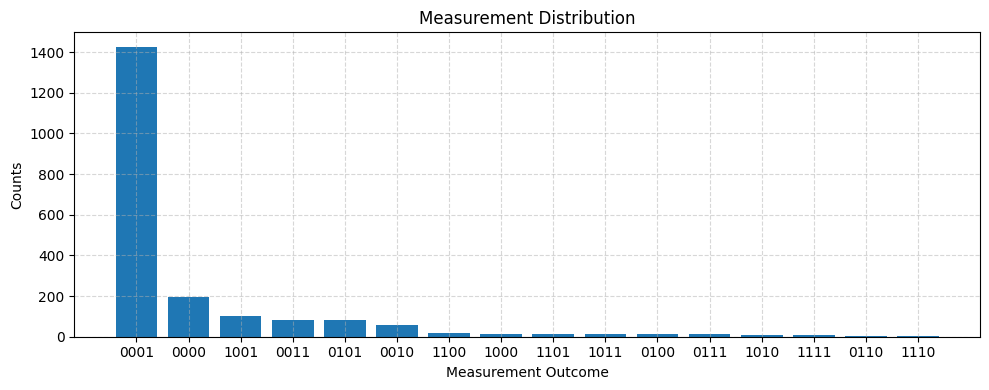

In [23]:
import matplotlib.pyplot as plt

sorted_counts = dict(sorted(pub_result.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 4))
plt.bar(sorted_counts.keys(), sorted_counts.values())
plt.xlabel("Measurement Outcome")
plt.ylabel("Counts")
plt.title("Measurement Distribution")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [94]:
N = X_train.shape[0]
kernel_matrix = np.full((N, N), np.nan)
for i in range(kernel_matrix.shape[0]):
    for j in range(i,kernel_matrix.shape[1]):
        if i == j:
            kernel_matrix[i,j] = 1
        else:
            kernel_matrix[i,j] = kernel.kappa(X_train[i], X_train[j])
            kernel_matrix[j,i] = kernel_matrix[i,j]
print(kernel_matrix)

TypeError: 'NoneType' object is not subscriptable

In [16]:
K_train = kernel.build_kernel(X_train, X_train, matrix="train")

TypeError: 'NoneType' object cannot be interpreted as an integer

In [ ]:
# Predict the labels for the test data
K_test = kernel.build_kernel(X_test, X_train)
y_pred = model.predict(K_test)

In [ ]:
# Calculate the accuracy
accuracy = np.sum(y_test == y_pred) / len(y_test)
print("Accuracy:", accuracy)

In [ ]:
from quask.evaluator import CenteredKernelAlignmentEvaluator
ce = CenteredKernelAlignmentEvaluator()
cost_tr = ce.evaluate(None, K_train, X_train, y_train)
cost_te = ce.evaluate(None, K_test, X_test, y_test)
print("The cost for training kernel according to the Centered-KTA is:", cost_tr)
print("The cost for testing kernel according to the Centered-KTA is:", cost_te)

TESTING BELOW

In [11]:
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

# Example factory for a noiseless QiskitKernel (Aer/Estimator path)
def create_qiskit_noiseless(ansatz, measurement: str, type: KernelType):
    # Here platform="infty_shots" forces Estimator/Aer path inside QiskitKernel
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="infty_shots",
        n_shots=None  # None means no sampling, use statevector/estimator
    )


_service = QiskitRuntimeService()  # ensure credentials/configured
_backend = _service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")
_options = {
    "dynamical_decoupling": {"sequence_type": "XX", "enable": False},
    "twirling": {"enable_gates": False, "enable_measure": False, "num_randomizations": "auto", "shots_per_randomization": "auto"}
}

# Example factory for a real IBM backend with given options
def create_qiskit_ibm(ansatz, measurement: str, type: KernelType):
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="ibm_quantum",    # or leave default so QiskitKernel picks job mode
        n_shots=2048,
        options=_options,
        backend=_backend,
    )

/tmp/ipykernel_13716/3072117387.py:17: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  _service = QiskitRuntimeService()  # ensure credentials/configured


In [12]:
from quask.core import KernelFactory, Ansatz

# Register the noiseless factory
KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
# Register the IBM backend factory
# KernelFactory.add_implementation('qiskit_ibm', create_qiskit_ibm)

# Choose which one is the default for create_kernel calls:
KernelFactory.set_current_implementation('qiskit_noiseless')
# ...later, if you want to switch:
# KernelFactory.set_current_implementation('qiskit_ibm')


In [9]:
print(X_train)

[[ 1.37799848 -0.50261736  1.12819704  0.84274983]
 [-0.71360635 -1.82529463  0.26035316  0.33709993]
 [-0.4675352   1.08459536 -1.00803404 -1.01129979]
 [ 1.2549629  -0.76715282  1.12819704  1.17984976]
 [ 1.13192732  0.290989    1.06143982  1.17984976]
 [-0.71360635  0.02645355 -0.94127682 -1.17984976]
 [-1.08271309  0.82005991 -1.00803404 -0.84274983]
 [ 0.02460712 -2.08983008  0.72765371  0.84274983]
 [ 1.00889174  0.55552445  1.19495426  1.34839972]
 [ 1.74710521  0.02645355  1.3284687   1.17984976]]


In [ ]:
# Make sure ansatz is defined before creating the kernel:
ansatz = Ansatz(n_features=4, n_qubits=4, n_operations=4)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.9)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XX", new_bandwidth=0.9)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XX", new_bandwidth=0.9)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="XX", new_bandwidth=0.9)

# Now create via factory:
kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)
# This will invoke whichever implementation is current (e.g., create_qiskit_noiseless).
kernel.service = _service

print(X_train[0])

# batch all jobs in a session
with Session(backend=backend) as session:
    kernel._session = session
    kernel._sampler = Sampler(session=session)

    K_train = kernel.build_kernel(X_train, X_train, matrix="train")

print(K_train)
model.fit(K_train, y_train)


[ 1.37799848 -0.50261736  1.12819704  0.84274983]


/mnt/c/users/maryc/onedrive/desktop/Quantum Research 2025/.venv/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


Job sent to hardware. Job ID: d193grbv3z50008a0t8g
Job sent to hardware. Job ID: d193t50qf56g008zhkbg
Job sent to hardware. Job ID: d193tkt3grvg008mgcxg


KeyboardInterrupt: 

In [45]:
K_train = kernel.build_kernel(X_train, X_train, matrix="train")
model.fit(K_train, y_train)

Job sent to hardware. Job ID: d192dqyn2txg008dvcrg


TypeError: float() argument must be a string or a real number, not 'RuntimeJobV2'

In [40]:
# Predict the labels for the test data
K_test = kernel.build_kernel(X_test, X_train, matrix="test")
y_pred = model.predict(K_test)

In [41]:
# Calculate the accuracy
accuracy = np.sum(y_test == y_pred) / len(y_test)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [42]:
from quask.evaluator import CenteredKernelAlignmentEvaluator
ce = CenteredKernelAlignmentEvaluator()
cost_tr = ce.evaluate(None, K_train, X_train, y_train)
cost_te = ce.evaluate(None, K_test, X_test, y_test)
print("The cost for training kernel according to the Centered-KTA is:", cost_tr)
print("The cost for testing kernel according to the Centered-KTA is:", cost_te)

The cost for training kernel according to the Centered-KTA is: -0.261090969853124
The cost for testing kernel according to the Centered-KTA is: -0.3555729011242078


switch to IBM backend

In [43]:
KernelFactory.set_current_implementation('qiskit_ibm')
kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)
# Now it uses the IBM backend path.
